# Ground Truth でシンプルなラベリングタスクを実施する

このノートブックでは，Ground Truth を使った簡単なラベリングタスクを実際に行ってみることで，どのように Ground Truth を使うか理解することを目的とします．

## セットアップ

まずラベリングジョブを行うためのデータ，および IAM ポリシーを作成します．

### データのセットアップ

データについては，以下のコマンドで処理対象のデータをダウンロードして，中身を確認します．

In [21]:
!rm -r data && aws s3 cp s3://makotosh-dataset/animal.zip ./data/ && unzip data/animal.zip -d data/

download: s3://makotosh-dataset/animal.zip to data/animal.zip     
Archive:  data/animal.zip
   creating: data/animal/cat/
  inflating: data/animal/cat/cat001.jpg  
  inflating: data/animal/cat/cat002.jpg  
  inflating: data/animal/cat/cat003.jpg  
   creating: data/animal/dog/
  inflating: data/animal/dog/dog001.jpg  
  inflating: data/animal/dog/dog002.jpg  
  inflating: data/animal/dog/dog003.jpg  
  inflating: data/animal/manifest.json  


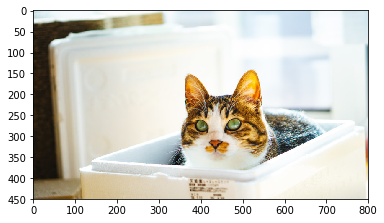

In [22]:
% matplotlib inline 

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

im = Image.open('data/animal/cat/cat001.jpg', 'r')
plt.imshow(np.array(im))

続いて，ジョブを実行する際にファイル一覧を記述する，manifest.json ファイルを確認します．

In [23]:
!cat data/animal/manifest.json

{"source-ref": "s3://makotosh-dataset/animal/dog/dog001.jpg"}
{"source-ref": "s3://makotosh-dataset/animal/dog/dog002.jpg"}
{"source-ref": "s3://makotosh-dataset/animal/dog/dog003.jpg"}
{"source-ref": "s3://makotosh-dataset/animal/cat/cat001.jpg"}
{"source-ref": "s3://makotosh-dataset/animal/cat/cat002.jpg"}
{"source-ref": "s3://makotosh-dataset/animal/cat/cat003.jpg"}



### S3 バケットの作成とデータのアップロード

ラベリングジョブの出力結果を格納するためのバケットを作成します．以下の内容に対して，以下のようにバケット名を置き換えてから，コマンドを実行してください．S3 バケットは必ず一意なものを作成する必要があるためです．変更しないでバケット作成を行うと，エラーが出ます．

- YYYYMMDD: 20190214 のように，このハンズオンを実施する日付
- XXX: 001 のように，ハンズオン実施時に指定された番号

In [26]:
!aws s3api create-bucket --bucket sagemaker-labelling-job-YYYYMMDD-XXX

{
    "Location": "/sagemaker-labelling-job-20190129-002"
}


続いてデータをアップロードします．バケット名を，上で作成したものに変更してから，以下のコマンドを実行してください．

In [31]:
!aws s3 cp data/animal s3://sagemaker-labelling-job-YYYYMMDD-XXX/animal/input --recursive

upload: data/animal/manifest.json to s3://sagemaker-labelling-job-20190129-002/animal/input/manifest.json
upload: data/animal/dog/dog003.jpg to s3://sagemaker-labelling-job-20190129-002/animal/input/dog/dog003.jpg
upload: data/animal/cat/cat003.jpg to s3://sagemaker-labelling-job-20190129-002/animal/input/cat/cat003.jpg
upload: data/animal/dog/dog001.jpg to s3://sagemaker-labelling-job-20190129-002/animal/input/dog/dog001.jpg
upload: data/animal/cat/cat002.jpg to s3://sagemaker-labelling-job-20190129-002/animal/input/cat/cat002.jpg
upload: data/animal/cat/cat001.jpg to s3://sagemaker-labelling-job-20190129-002/animal/input/cat/cat001.jpg
upload: data/animal/dog/dog002.jpg to s3://sagemaker-labelling-job-20190129-002/animal/input/dog/dog002.jpg


### ポリシーの準備

[IAM 管理ページ](https://console.aws.amazon.com/iam/home?region=us-east-1#/users) に移動して，ラベリングジョブを行うユーザーに対して，以下のポリシーを付与してください．この作業は，あらかじめハンズオンの前に亜kん理社側で実施しておくことを推奨します．

```
{
    "Version": "2012-10-17",
    "Statement": [
        {
            "Sid": "sagemakergroundtruth",
            "Effect": "Allow",
            "Action": [
                "cognito-idp:CreateGroup",
                "cognito-idp:CreateUserPool",
                "cognito-idp:CreateUserPoolDomain",
                "cognito-idp:AdminCreateUser",
                "cognito-idp:CreateUserPoolClient",
                "cognito-idp:AdminAddUserToGroup",
                "cognito-idp:DescribeUserPoolClient",
                "cognito-idp:DescribeUserPool",
                "cognito-idp:UpdateUserPool"
            ],
            "Resource": "*"
        }
    ]
}```

### ラベリングジョブを行うチームの作成

[SageMaker コンソールのラベリング労働力ページ](https://console.aws.amazon.com/sagemaker/groundtruth?region=us-east-1#/labeling-workforces) に移動して，上のメニューから「Private」を選択し，「Create private team」を選択してください．続いて以下のように入力したら，Create private team を押します．

- Team name: `private-team-XXX` と入力してください．XXX は先ほどと同様に，ハンズオン開始時に指定された番号になります
- Add workers: `Create a new Amazon Cognito user group` を選択してください

元の画面に戻ったら，Private teams 内に，作成したチームが表示されています（表示されていない場合は，画面をリロードしてください）．続いて 画面下側の Workers から Invite new workers を選択して，自分のメールアドレスを入力したらInvite new workers を押します．しばらくすると，入力したメールアドレスに，Amazon SageMaker から招待リンクの含まれたメールが届きます．そうしたら，リンクをクリックして，メールに書かれたユーザー名とパスワードを使ってログインし，パスワードを変更します．

Worker を作成したら，次に Team に Worker を登録します．Private teams 内のチーム名をクリックして詳細画面に進んだら，画面中ほどの Workers タブを選んで，Add workers to team を押します．ここで作成した Worker を選択したら，右下のボタンを押して，Worker の追加を完了します．これで準備ができました．

## ラベリングジョブの作成

[SageMaker コンソールのラベリングジョブページ](https://console.aws.amazon.com/sagemaker/groundtruth?region=us-east-1#/labeling-jobs) に移動して，`Create labelling job ` ボタンをクリックします．その後以下のように入力を行ってから，「Next」ボタンを押してください．

- Job name: 適当なジョブ名を入力してください．ただし半角英数およびハイフンで，64 文字以内の必要があります．
- Input dataset location: `s3://sagemaker-labelling-job-YYYYMMDD-XXX/animal/input/manifest.json` を指定します．
- Output dataset location: `s3://sagemaker-labelling-job-YYYYMMDD-XXX/animal/JOBNAME` のように，上で作成したバケット名 + animal + ジョブ名を指定してください．
- IAM role: 先ほど IAM ポリシーを付与した IAM ロールを選んでください

その上で，Task type として Image classification を選択したら Next を押してください．

次のページでは，順番に以下のように選択してください．

- Worker types: Private を選択
- Private teams: 先ほど作成したチームを選択

その上で，Image classification labelling tool について，以下のように追加情報の入力を行います．

- Enter a brief description of the task: タスクに関する説明文を各フィールドです．ここでは「画像分類のテスト」と入力してください
- Select an option: 2 つのフィールドに対して「dog」「cat」とそれぞれ入力してください．このフィールドには日本語は使用できません

これらが終わったら Submit ボタンを押してください．

## ラベリングジョブの実施

あとは，先ほどの Worker 側作業ページを開いて待っていると，分類タスクが積まれます．実際にラベリングタスクを試してみてください．

![labelling_image](./img/img001.jpg)

ジョブが終了したら，マネジメントコンソール内のラベリングジョブの一覧から，実行したジョブを選択して，Output dataset location をクリックしてください．アウトプットフォルダは，以下のような階層構造になっています．

- s3://PATH/TO/JOB/OUTPUT/activelearning: 自動ラベリング機能を使った時に，その結果を格納するディレクトリです
- s3://PATH/TO/JOB/OUTPUT/annotations: 人手によるラベリングジョブの結果が格納されるディレクトリです．個々人のラベリング結果を入れる worker-responce サブディレクトリ，各バッチごとのアノテーション結果をまとめた consolidated-annotation サブディレクトリ，バッチ内の判定結果をマニフェストファイルの形に落とした intermediate サブディレクトリの 3 つが含まれます
- s3://PATH/TO/JOB/OUTPUT/inference: 自動ラベリング機能の実施時の，バッチ推論ジョブの入出力データが格納されるディレクトリです
- s3://PATH/TO/JOB/OUTPUT/manifests: 最終結果のマニフェストファイルが格納されるディレクトリです
- s3://PATH/TO/JOB/OUTPUT/training: 自動ラベリング機能の実施時の，学習ジョブに関するデータが格納されるディレクトリです

では，最終的なラベリング結果を取得して中身を確認しましょう．下記コマンドを実行する前に，YYYYMMDD, XXX, JOBNAME を適宜変更してください．

In [ ]:
!aws s3 cp s3://sagemaker-labelling-job-YYYYMMDD-XXX/animal/JOBNAME/JOBNAME/manifests/output/output.manifest ./ && cat output.manifest